# Simple Examples of Solving PDEs with DL

In [1]:
import time
import math

import torch
from torch import nn, autograd, optim

%matplotlib notebook 
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from nets import *
from pdes import *
from utils import *
from graphics import *
from solutions import *

## Advection Equation

### Numerical Solution
explicit finite-difference scheme

$$
\left\{\begin{aligned}
    &u_i^{n+1} = u_i^n - \frac{a\Delta t}{(\Delta x)^2} (u_i^n- u_{i-1}^n)\\
    &u_i^0 = \exp(-\alpha(i\Delta h - 0.25)^2)\\
    &u_0^n = 0
\end{aligned}\right.
$$

In [2]:
l = 1
T = 1
dx = 1e-3
a = .5

initial = lambda x: dome(x, shift=.25)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
solver = AdvectionSolver(initial, a, l, T, dx, device)
x = solver.x

u_approx = solver.solve(True)
u_exact = dome(x, t=T, a=a, shift=.25)

max error 0.011359453201293945
avg error 0.003279679222032428


<IPython.core.display.Javascript object>


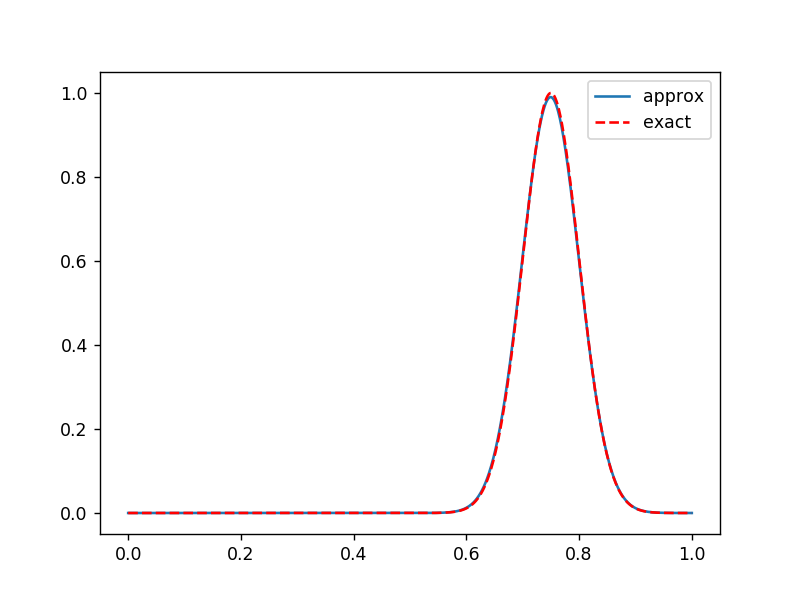

In [3]:
print('max error', max_error(u_exact, u_approx).item())
print('avg error', avg_error(u_exact, u_approx).item())
plt.figure()
plt.plot(x.cpu(), u_approx.cpu(), label='approx')
plt.plot(x.cpu(), u_exact.cpu(), '--r', label='exact')
plt.legend();

### Solution obtained with DL

In [14]:
num_batches = int(1e4)
# in fact, 10,000 iterations is more than enough
# to obtain a decent approximation in the training domain
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
initial = lambda x: dome(x, alpha=200., shift=.25)
pde = AdvectionPDE(initial, device=device)

#net = DGM(d=1, M=50, L=3).to(device)
net = DumbLinear('3l', base_width=128).to(device)

n_devices = torch.cuda.device_count()
print(f'You have {n_devices} gpus')
if n_devices > 1:
    net = nn.DataParallel(net,  np.arange(n_devices))
    
optimizer = optim.Adam(net.parameters())
loss_history = []

You have 0 gpus


In [15]:
try:
    train(net, pde, optimizer, loss_history, num_batches, 128)
except KeyboardInterrupt:
    pass

Training: 100%|██████████| 10000/10000 [02:52<00:00, 58.09it/s]


<IPython.core.display.Javascript object>


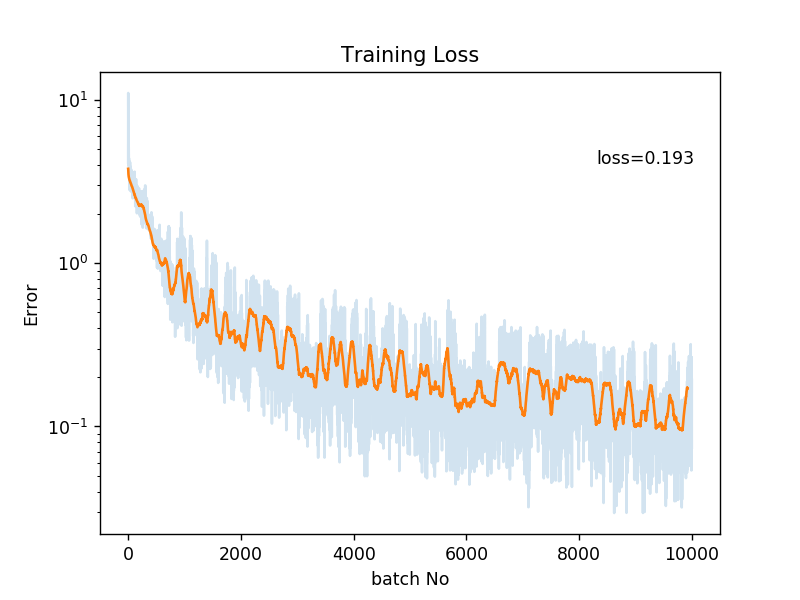

In [17]:
fig, ax = plt.subplots()
ax.plot(loss_history, alpha=.2)
ax.text(.8, .8, 'loss={:.3f}'.format(loss_history[-1]), transform = ax.transAxes)
ax.plot(running_mean(loss_history))
ax.set_yscale('log')
ax.set_ylabel('Error')
ax.set_xlabel('batch No')
plt.title('Training Loss');

### Initial condition approximation

max error 0.02591240406036377
avg error 0.017154518514871597


<IPython.core.display.Javascript object>


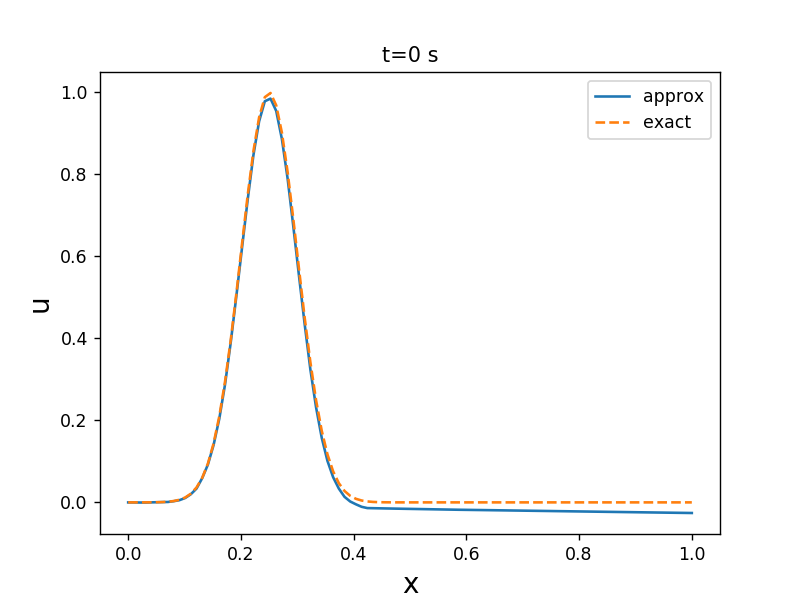

In [18]:
x = torch.linspace(0, 1, device=device)
o = torch.zeros_like(x)

y_true = dome(x, shift=.25)
y = net(o, x).detach()
print('max error', max_error(y_true, y).item())
print('avg error', avg_error(y_true, y).item())
x = x.cpu()
y = y.cpu()
y_true = y_true.cpu()

plt.figure()
plt.plot(x, y, label='approx')
plt.plot(x, y_true, '--', label='exact')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title('t=0 s')
plt.legend();

### Approximation at time `t`

max error 0.026529043912887573
avg error 0.012581671588122845


<IPython.core.display.Javascript object>


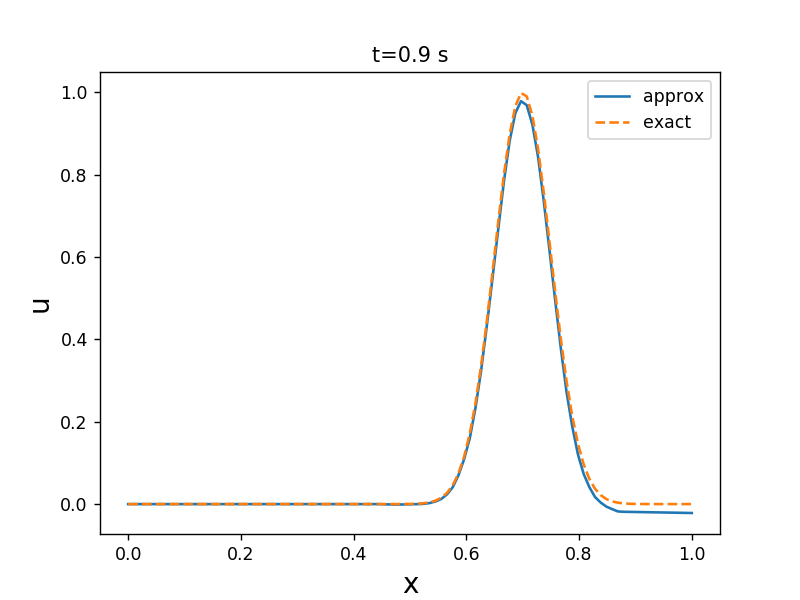

In [19]:
t_val = .9 
x = torch.linspace(0, 1, device=device)
t = torch.empty_like(x).fill_(t_val)

y_true = dome(x, t_val, shift=.25)
y = net(t, x).detach()
print('max error', max_error(y_true, y).item())
print('avg error', avg_error(y_true, y).item())
x = x.cpu()
y = y.cpu()
y_true = y_true.cpu()

plt.figure()
plt.plot(x, y, label='approx')
plt.plot(x, y_true, '--', label='exact')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title(f't={t_val} s')
plt.legend();

### Run cell to start animating
if there is only one graph, re-run the cell

---
As expected, the approximation is fairly good on the training data, and when the model encounters test data the solutions begin to diverge

<IPython.core.display.Javascript object>


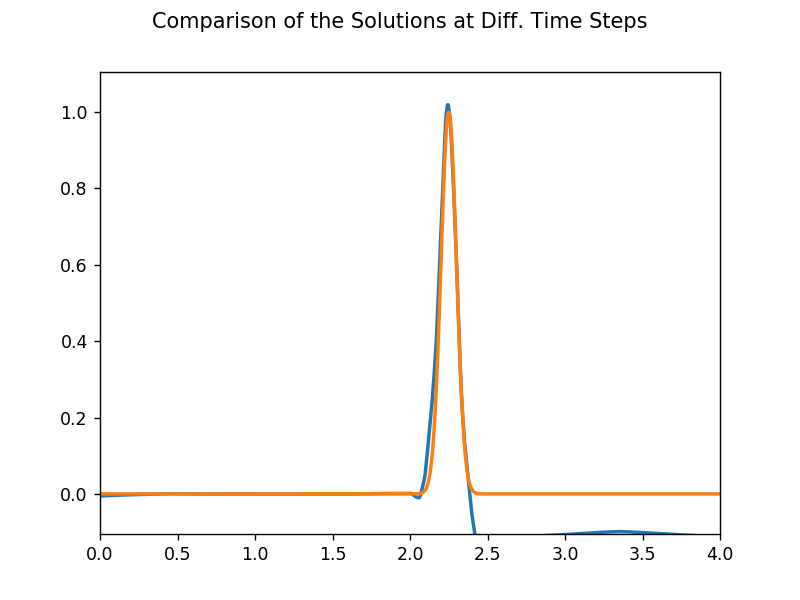

In [30]:
z = torch.linspace(0, 4, 1000)
t = torch.linspace(0, 4)
y = dome(z, t, shift=.25)
true_data = (z, y)

t, x = torch.meshgrid(t, z)
y = net(t.to(device), x.to(device)).detach().cpu()
appr_data = (z, y)

fig = plt.figure()
fig.suptitle('Comparison of the Solutions at Diff. Time Steps')
Anime(fig, appr_data)
Anime(fig, true_data);

# test data begins when dome at x = a * T = .5 * 2 = 1

---
## Fisher-Kolmogorov Equation
### Numerical Solution
finite-difference (explicit and implicit schemes) and nonstandard finite-difference methods

---
* **Case described in [the paper](https://core.ac.uk/download/pdf/82343686.pdf)**
$$
\left\{\begin{aligned}
    &u_t - u\,u_{xx} = u(1-u), &&\quad (t,x) \in [0,T]\times[0, l]\\
    &u(0, x) = 0, &&\quad x \in (0,l]\\
    &u(t, 0) = 1, &&\quad t \in [0,T]\\
    &u(t, l) = 0, &&\quad t \in [0,T]\\
    &0 \le u(t, x) \le 1\\
\end{aligned}\right.
$$

**Nonstandard Finite Difference Method (NSFDM)** for the problem above

$$
    \frac{u^{n+1}_m - u^n_m}{\phi(\Delta t)}
    = u^{n+1}_m \left[\frac{u^n_{m+1} - 2u^n_m + u^n_{m-1}}{\psi(\Delta x)}\right]
    + 2\bar u^n_m - u^{n+1}_m - u^{n+1}_m \bar u^n_m
$$

$$
    \bar u^n_m \equiv \frac{u^n_{m+1} + u^n_{m-1}}{2}
$$

One can check that this scheme is stable (considering that initial values of $0 < u < 1$)
if $\frac{\phi(\Delta t)}{\psi(\Delta x)} \lt \frac{1}{2}$ (without any spectral analysis).
The stability condition might be or might be not weakened, if analyzed more thoroughly

Here, the 'denominator function' (calling such both $\psi$ and $\phi$ in general) satisfies:

$$
    \varphi(h, \lambda) = h + O(h^2)
$$

$\lambda$ is some hyperparameter that might appear in PDEs (as an example of $\varphi$ you can consider $\exp(\bullet) - 1$)  
For the sake of simplicity, we can take $\quad\phi(\Delta t) = \Delta t, \qquad \psi(\Delta x) = (\Delta x)^2$  
What else is worth mentioning here is that terms $u$ and $u^2$ are discretized non-locally
($u \to 2\bar u^n_m - u^{n+1}_m$ instead of just $u^n_m$, and likewise, $u^2 \to u^{n+1}_m\bar u^n_m$)  
Local discretization in turn prevents the propagation of diffusion process (see in [the paper](https://core.ac.uk/download/pdf/82343686.pdf) how)

This scheme is explicit, so we can write
$$
    u^{n+1}_m = \frac{u^n_m + 2\phi\bar u^n_m}{1+ \phi + \frac{2\phi}{\psi}(u^n_m - \bar u^n_m)+\phi\bar u^n_m}
$$

* **Explicit scheme for FK equation**

Also, we can consider similar problem:

$$
\left\{\begin{aligned}
    &u_t - a\,u_{xx} = ru(1-u), &&\quad (t,x) \in [0,T]\times[0, l]\\
    &u(0, x) = g(x), &&\quad x \in [0,l]\\
    &u(t, 0) = g(0), &&\quad t \in [0,T]\\
    &u(t, l) = g(l), &&\quad t \in [0,T]\\
    &0 \le u(t, x) \le 1\\
\end{aligned}\right.
$$

For this problem formulation, we can write the following explicit scheme
($u \to \bar u^n_m,\; u^2 \to u^{n+1}_m \bar u^n_m)$:

$$
    u^{n+1}_m = \frac{(1 - \frac{2a\phi}{\psi})u^n_m + \frac{2a\phi}{\psi}\bar u^n_m + r\phi\bar u^n_m}
    {1 + r\phi\bar u^n_m}
$$

With simple stability analysis, we have $\frac{2a\phi(\Delta t)}{\psi(\Delta x)} \lt 1$:  

$$
    u^{n+1}_m \ge 0 \quad\longrightarrow\quad \left(1 - \frac{2a\phi}{\psi}\right)u^n_m + \frac{2a\phi}{\psi}\bar u^n_m + r\phi\bar u^n_m \ge 0, \quad\forall u^n_m, \bar u^n_m \in [0, 1]\\
    \Longrightarrow 1 - \frac{2a\phi}{\psi} \ge 0
$$

$$
    u^{n+1}_m \le 1 \quad\longrightarrow\quad \left(1 - \frac{2a\phi}{\psi}\right)u^n_m + \frac{2a\phi}{\psi}\bar u^n_m + r\phi\bar u^n_m \;\le\; 1 + r\phi\bar u^n_m\\
    \left(1 - \frac{2a\phi}{\psi}\right)u^n_m + \frac{2a\phi}{\psi}\bar u^n_m \;\le\; 1, \quad\forall u^n_m, \bar u^n_m \in [0, 1]\\
$$

Considering all possible $u^n_m, \bar u^n_m \in [0, 1]$, we come to the condition above

* **Implicit scheme**

$$
    \frac{u^n_m - u^{n-1}_m}{\phi(\Delta t)}
    = a\frac{u^n_{m+1} - 2u^n_m + u^n_{m-1}}{\psi(\Delta x)}
    + ru(1-u)
$$

$$
    -\mu u^n_{m-1} + (1+2\mu)u^n_m - \mu u^n_{m+1}
    = u^{n-1}_m + r\phi u^{n-1}_m(1-\bar u^{n-1}_m)
$$

Where $\mu = \frac{a\phi}{\psi}$  
Rewrite it as the system

$$\begin{pmatrix}
1+2\mu& -\mu \\
-\mu& 1+2\mu& -\mu\\
& \ddots & \ddots & \ddots\\
& &  -\mu& 1+2\mu& -\mu\\
& & & -\mu& 1+2\mu
\end{pmatrix}
\begin{pmatrix}
U^n_1 \\
U^n_2 \\
\vdots \\
U^n_{M-3}\\
U^n_{M-2}
\end{pmatrix}
= \begin{pmatrix}
U^{n-1}_1(1 - r\phi\bar U^{n-1}_1) + \mu g_0\\
U^{n-1}_2(1 - r\phi\bar U^{n-1}_2)\\
\vdots\\
U^{n-1}_{M-3}(1 - r\phi\bar U^{n-1}_{M-3})\\ 
U^{n-1}_{M-2}(1 - r\phi\bar U^{n-1}_{M-2}) + \mu g_M\\
\end{pmatrix}
$$

**Stability analysis**

The matrix is p.d. $\rightarrow$ the scheme is unconditionally stable (\*almost)

**Cholesky decomposition of a 3-diagonal symmetric matrix**

$$
\begin{pmatrix}
    a& b \\
    b& a& b\\
    & \ddots & \ddots & \ddots\\
    & &  b& a& b\\
    & & & b& a
\end{pmatrix}
=
\begin{pmatrix}
    l_0\\
    m_0& l_1\\
    & \ddots & \ddots\\
    & & m_{n-3}& l_{n-2}\\
    & & & m_{n-2}& l_{n-1}\\
\end{pmatrix}
\begin{pmatrix}
    l_0& m_0\\
    & l_1 & m_1\\
    & & \ddots & \ddots\\
    & & & l_{n-2}& m_{n-2}\\
    & & & & l_{n-1}\\
\end{pmatrix}
$$

To determine $L$
$$
    a = A_{00} = l_0^2\\
    a = A_{ii} = m_{i-1}^2 + l_i^2, \quad i > 0\\
    b = A_{i-1, i} = A_{i,i-1} = m_{i-1}l_{i-1}, \quad i > 0
$$

$$
\begin{pmatrix}
    l_0\\
    m_0& l_1\\
    & \ddots & \ddots\\
    & & m_{n-3}& l_{n-2}\\
    & & & m_{n-2}& l_{n-1}\\
\end{pmatrix}
\begin{pmatrix}
    y_0\\
    y_1\\
    \vdots\\
    y_{n-2}\\
    y_{n-1}
\end{pmatrix}
=
\begin{pmatrix}
    f_0\\
    f_1\\
    \vdots\\
    f_{n-2}\\
    f_{n-1}
\end{pmatrix}
$$

To solve $Ly = f$:
$$
    l_0y_0 = f_0\\
    m_{i-1}y_{i-1} + l_iy_i = f_i, \quad i > 0
$$

$$
\begin{pmatrix}
    l_0& m_0\\
    & l_1 & m_1\\
    & & \ddots & \ddots\\
    & & & l_{n-2}& m_{n-2}\\
    & & & & l_{n-1}\\
\end{pmatrix}
\begin{pmatrix}
    x_0\\
    x_1\\
    \vdots\\
    x_{n-2}\\
    x_{n-1}
\end{pmatrix}
=
\begin{pmatrix}
    y_0\\
    y_1\\
    \vdots\\
    y_{n-2}\\
    y_{n-1}
\end{pmatrix}
$$

To solve $L^\top x = y$:
$$
    l_ix_i + m_ix_{i+1} = y_i, \quad i < N-1\\
    l_{n-1}x_{n-1} = y_{n-1}
$$

* **Analytical solution for $r=0$**
$$\left\{\begin{aligned}
    &u_t - a\,u_{xx} = 0, &&\quad (t,x) \in [0,T]\times[0, l],\; a > 0\\
    &u(0, x) = e^{-\alpha |x-\frac{l}{2}|}, &&\quad x \in [0,l]\\
    &u(t, 0) = e^{-\alpha \frac{l}{2}}, &&\quad t \in [0,T]\\
    &u(t, l) = e^{-\alpha \frac{l}{2}}, &&\quad t \in [0,T]\\
\end{aligned}\right.$$

---
Zero the boundary conditions by:
    $$u = v + e^{-\alpha\frac{l}{2}}$$
    
Which gives:
$$\left\{\begin{aligned}
    &v_t - a\,v_{xx} = 0, &&\quad (t,x) \in [0,T]\times[0, l]\\
    &v(0, x) = e^{-\alpha |x-\frac{l}{2}|} - e^{-\alpha\frac{l}{2}}, &&\quad x \in [0,l]\\
    &v(t, 0) = 0, &&\quad t \in [0,T]\\
    &v(t, l) = 0, &&\quad t \in [0,T]\\
\end{aligned}\right.$$

---
Seeking the solution in the form $v \sim \sum_k \Theta_k(t)X_k(x)$.  
$\left(\Theta' X = a\Theta X'' \rightarrow \frac{\Theta'}{a\Theta} = \frac{X''}{X} = -\lambda\right)$  
The spatial basis' functions are eigenfunctions of the operator $-\frac{d^2}{dx^2}$:

$$
    X_k(x) = \sin\frac{\pi k}{l} x, \quad k = \overline{1, \infty}
$$

Expand $v(0, x)$ in the basis of $X_k$:

$$
    -\frac{2}{l}e^{-\alpha\frac{l}{2}}\int_0^l \sin\frac{\pi k}{l}x\;dx
    =\color{red}{\frac{2}{\pi k}e^{-\alpha\frac{l}{2}}\big(\cos\pi k - 1\big)}\\
    \frac{2}{l}\int_0^l e^{-\alpha |x-\frac{l}{2}|}\sin\frac{\pi k}{l}x\;dx
    = \frac{2}{l}\int_0^\frac{l}{2} e^{\alpha (x-\frac{l}{2})}\sin\frac{\pi k}{l}x\;dx
    + \frac{2}{l}\int_\frac{l}{2}^l e^{-\alpha (x-\frac{l}{2})}\sin\frac{\pi k}{l}x\;dx
$$

&nbsp;&nbsp;

$$
    J_1 = \frac{2}{l}\int_0^\frac{l}{2} e^{\alpha (x-\frac{l}{2})}\sin\frac{\pi k}{l}x\;dx = 
    \frac{2}{\pi k}\int_0^\frac{\pi k}{2} e^{\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\sin y\;dy\\
    =\frac{2}{\alpha l}e^{\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\sin y\;\bigg|_0^\frac{\pi k}{2}
    -\frac{2}{\alpha l}\int_0^\frac{\pi k}{2} e^{\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\cos y\;dy\\
    =\frac{2}{\alpha l}\sin\frac{\pi k}{2}
    -\frac{2 \pi k}{(\alpha l)^2}e^{\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\cos y\;\bigg|_0^\frac{\pi k}{2}
    -\left(\frac{\pi k}{\alpha l}\right)^2\frac{2}{\pi k}
    \int_0^\frac{\pi k}{2} e^{\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\sin y\;dy\\
    =\frac{2}{\alpha l}\sin\frac{\pi k}{2}-\frac{2 \pi k}{(\alpha l)^2}\cos\frac{\pi k}{2}
    +\frac{2 \pi k}{(\alpha l)^2}e^{-\frac{\alpha l}{2}}
    -\left(\frac{\pi k}{\alpha l}\right)^2 J_1
$$

&nbsp;&nbsp;

$$
    J_2 = \frac{2}{l}\int_\frac{l}{2}^l e^{-\alpha (x-\frac{l}{2})}\sin\frac{\pi k}{l}x\;dx
    = \frac{2}{\pi k}\int_\frac{\pi k}{2}^{\pi k} e^{-\frac{\alpha l}{\pi k}(y-\frac{\pi k}{2})}\sin y\;dy\\
    =-\frac{2}{\alpha l}e^{-\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\sin y\;\bigg|_\frac{\pi k}{2}^{\pi k}
    +\frac{2}{\alpha l}\int_\frac{\pi k}{2}^{\pi k} e^{-\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\cos y\;dy\\
    =\frac{2}{\alpha l}\sin\frac{\pi k}{2}
    -\frac{2\pi k}{(\alpha l)^2}e^{-\frac{\alpha l}{\pi k}
    (y-\frac{\pi k}{2})}\cos y\;\bigg|_\frac{\pi k}{2}^{\pi k}
    -\left(\frac{\pi k}{\alpha l}\right)^2\frac{2}{\pi k}
    \int_\frac{\pi k}{2}^{\pi k} e^{-\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\sin y\;dy\\
    =\frac{2}{\alpha l}\sin\frac{\pi k}{2}
    -\frac{2\pi k}{(\alpha l)^2}e^{-\frac{\alpha l}{2}}\cos\pi k
    +\frac{2\pi k}{(\alpha l)^2}\cos \frac{\pi k}{2}
    -\left(\frac{\pi k}{\alpha l}\right)^2 J_2
$$

&nbsp;&nbsp;

$$
    J = J_1 + J_2 =  \frac{4}{\alpha l}\sin\frac{\pi k}{2}
    +\frac{2 \pi k}{(\alpha l)^2}e^{-\frac{\alpha l}{2}}(1 -\cos\pi k)
    -\left(\frac{\pi k}{\alpha l}\right)^2 (J_1 + J_2)\\
    J = \color{red}{\frac{4\alpha l\sin\frac{\pi k}{2}
    + 2\pi k e^{-\frac{\alpha l}{2}}(1 -\cos\pi k)}{\alpha^2l^2 + \pi^2k^2}}
$$

---
Frame the problem for the temporal part:

$$\left\{\begin{aligned}
    &\theta_k\,'(t) + \lambda_k a\;\theta_k(t) = 0, \quad t \in [0,T]\\
    &\theta_k(0) = A_k \\
\end{aligned}\right.$$

$$\theta_k(t) = A_ke^{-\lambda_k at}$$
Here $A_k$ is the sum of red expressions calculated above, and $\lambda_k = \left(\frac{\pi k}{l}\right)^2$  
Ultimately, we have for $v$:
$$u(t, x) = \sum_{k=1}^\infty A_ke^{-\lambda_k at} \sin\sqrt{\lambda_k} x$$

$$
    A_{2m} = 0\\
    A_{2m+1} = 4\frac{(-1)^m\alpha l + \pi(2m+1) e^{-\frac{\alpha l}{2}}}{\alpha^2l^2 + \pi^2(2m+1)^2}
    - \frac{4}{\pi (2m+1)}e^{-\frac{\alpha l}{2}}
$$

And for $u$:
$$u(t, x) = e^{-\alpha\frac{l}{2}} + \sum_{m=0}^\infty A_{2m+1}e^{-\lambda_{2m+1}at} \sin\sqrt{\lambda_{2m+1}} x$$

In [4]:
l = 1.
T = .1
r = 0.
dx = 1e-3
dt = 1e-3
a = 1e-1
alpha = 10.

initial = lambda x: spike(x, alpha=10., shift=.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
solver1 = ExplicitFisherSolver(initial, a, r, l, T, dx, device)

x = solver1.x
u0 = solver1.u0
solver2 = ImplicitFisherSolver(u0.cpu().numpy(), a, r, l, T, dx, dt)

u_ex = solver1.solve(True)
u_im = solver2.solve(True)

solver = PartialSolver(a, alpha, l)
u_exact = solver.solve(T, x, 1e-4)[0]

<IPython.core.display.Javascript object>


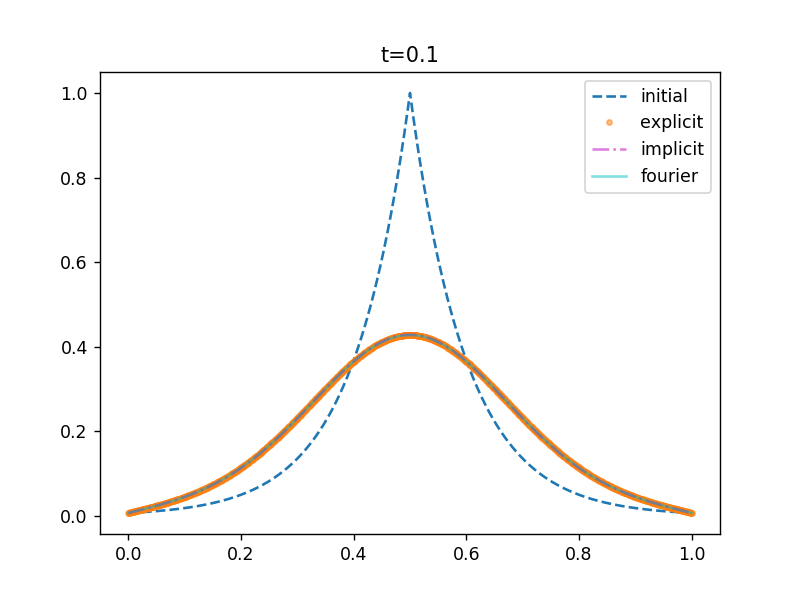

In [5]:
plt.figure()
plt.plot(x.cpu(), u0.cpu(), '--', label='initial')
plt.plot(x.cpu(), u_ex.cpu(), '.', label='explicit', alpha=.5)
plt.plot(x.cpu(), u_im, 'm-.', label='implicit', alpha=.5)
plt.plot(x.cpu(), u_exact.cpu(), 'c', label='fourier', alpha=.5)
plt.title(f't={T}')
plt.legend();

### Solution obtained with DL 

In [16]:
num_batches = int(1e4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
initial = lambda x: spike(x, alpha=10., shift=.5)
pde = FisherPDE(initial, device=device)

net = DGM(d=1, M=50, L=3).to(device)

n_devices = torch.cuda.device_count()
print(f'You have {n_devices} gpus')
if n_devices > 1:
    net = nn.DataParallel(net,  np.arange(n_devices))
    
optimizer = optim.Adam(net.parameters(), lr=1e-4)
loss_history = []

You have 0 gpus


In [12]:
try:
    train(net, pde, optimizer, loss_history, num_batches, 512)
except KeyboardInterrupt:
    pass

Training: 100%|██████████| 10000/10000 [23:32<00:00,  7.08it/s]


<IPython.core.display.Javascript object>


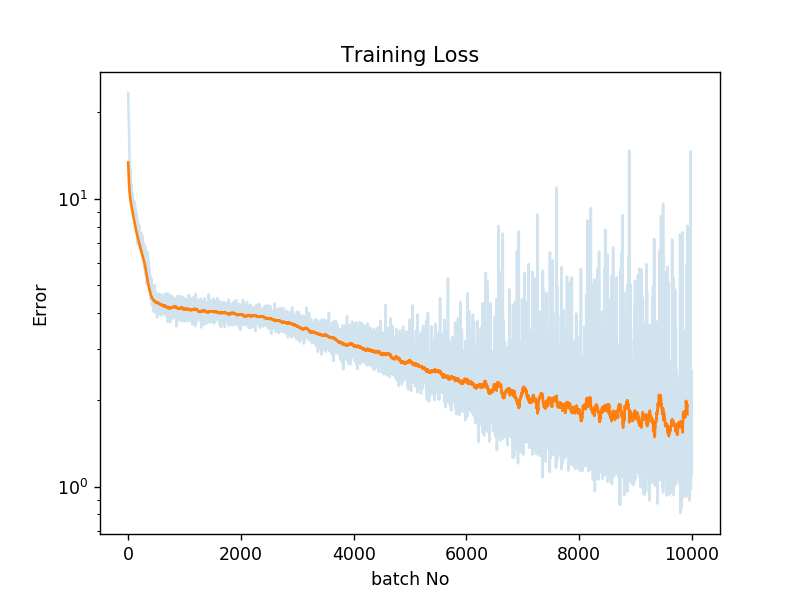

In [13]:
plt.figure()
loss = np.abs(loss_history)
plt.plot(loss, alpha=.2)
plt.plot(running_mean(loss))
plt.yscale('log')
plt.title('Training Loss')
plt.ylabel('Error')
plt.xlabel('batch No');

max error 0.029838472604751587
avg error 0.02207847312092781


<IPython.core.display.Javascript object>


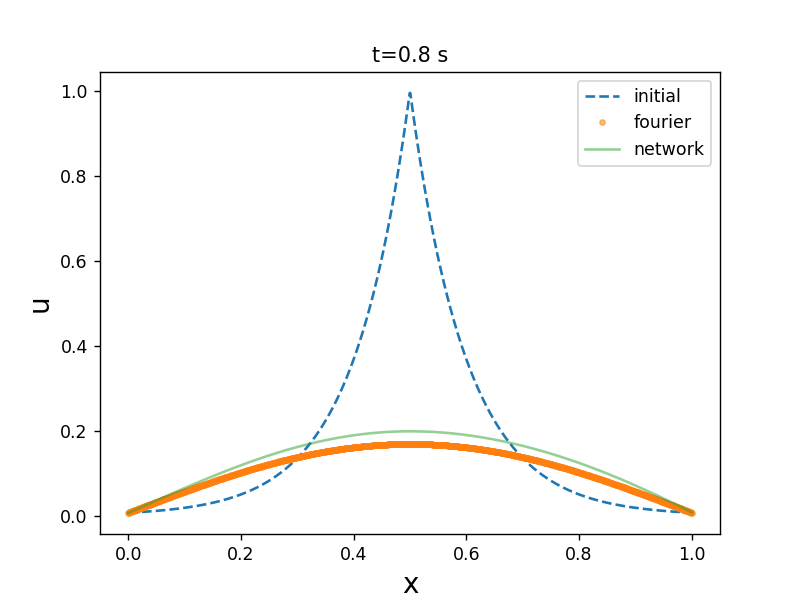

In [19]:
l = 1.
r = 0.
dx = 1e-3
a = .1
alpha = 10.

solver = PartialSolver(a, alpha, l)

t_val = .8
x = torch.linspace(0, 1, 1000, device=device)
y_initial = spike(x, shift=.5)

t = torch.empty_like(x).fill_(t_val)
y = net(t, x).detach()

y_true = solver.solve(t_val, x, 1e-4)[0]
print('max error', max_error(y_true, y).item())
print('avg error', avg_error(y_true, y).item())
x = x.cpu()

plt.figure() 
plt.plot(x, y_initial.cpu(), '--', label='initial')
plt.plot(x, y_true.cpu(), '.', label='fourier', alpha=.5)
plt.plot(x, y.cpu(), label='network', alpha=.5)
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title(f't={t_val} s')
plt.legend();

### Parametric Search

In [4]:
num_batches = int(1e4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
initial = lambda x: dome(x, alpha=200., shift=.5)
pde = ParametricFisherPDE(initial, device=device)

net = DGM(d=2, M=50, L=3).to(device)

n_devices = torch.cuda.device_count()
print(f'You have {n_devices} gpus')
if n_devices > 1:
    net = nn.DataParallel(net,  np.arange(n_devices))
    
optimizer = optim.Adam(net.parameters(), lr=1e-4)
loss_history = []

You have 0 gpus


In [5]:
try:
    train(net, pde, optimizer, loss_history, num_batches, 512)
except KeyboardInterrupt:
    pass

Training:   0%|          | 33/10000 [00:04<21:42,  7.65it/s]


In [ ]:
plt.figure()
loss = np.abs(loss_history)
plt.plot(loss, alpha=.2)
plt.plot(running_mean(loss))
plt.yscale('log')
plt.title('Training Loss')
plt.ylabel('Error')
plt.xlabel('batch No');

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
initial = lambda x: dome(x, alpha=200., shift=.5)
pde = ParametricFisherPDE(initial, device=device, r=(2.8, 3.2))
net = DGM(d=2, M=50, L=3).to(device)

checkpoint = torch.load('../weights/p-fisher.tar', map_location=device)
net.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

max difference 0.01706594228744507
avg difference 0.00947158969938755


<IPython.core.display.Javascript object>


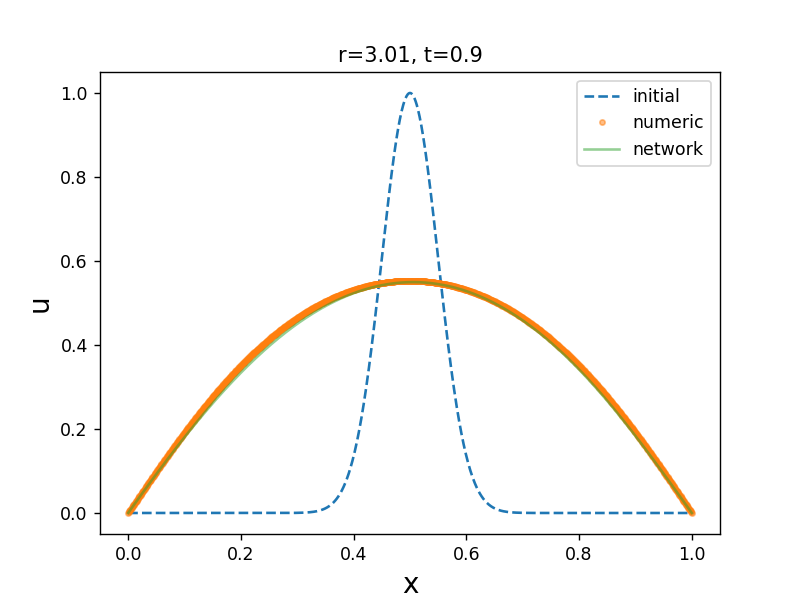

In [7]:
l = 1.
r = 3.01
dx = 1e-3
dt = 1e-3
a = .1
alpha = 10.

T = .9
x = torch.linspace(0, l, int(l/dx)+1)
u0 = initial(x).numpy()
solver = ImplicitFisherSolver(u0, a, r, l, T, dx, dt)

x = x.to(device)
t = torch.empty_like(x).fill_(T)
y = net(t, x, torch.ones_like(x)*r).detach()

y_true = np.array(solver.solve(True), 'f4')
print('max difference', max_error(torch.tensor(y_true), y.cpu()).item())
print('avg difference', avg_error(torch.tensor(y_true), y.cpu()).item())
x = x.cpu().numpy()

plt.figure() 
plt.plot(x, u0, '--', label='initial')
plt.plot(x, y_true, '.', label='numeric', alpha=.5)
plt.plot(x, y.cpu(), label='network', alpha=.5)
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title(f'r={r}, t={T}')
plt.legend();

In [9]:
l = 1.
dx = 1e-2
dt = 1e-2
a = .1
T = 1.

sizes = [int(l/dx)+1, int(T/dt)+1, 60]
xa, ta, ra = (
    torch.linspace(a, b, n, device=device)
    for (a, b), n in zip(pde.lims, sizes))

alpha = 200.
initial = lambda x: dome(x, alpha=alpha, shift=.5)
u0 = initial(xa.cpu()).numpy()

Y_true = []
for r in ra:
    solver = ImplicitFisherSolver(u0, a, r.item(), l, T, dx, dt)
    Y_true.append(solver.solve())
Y_true = np.array(Y_true, 'f4')

r, t, x = torch.meshgrid(ra, ta, xa)
Y = net(t, x, r).detach().cpu().numpy()
err = Y - Y_true

<IPython.core.display.Javascript object>


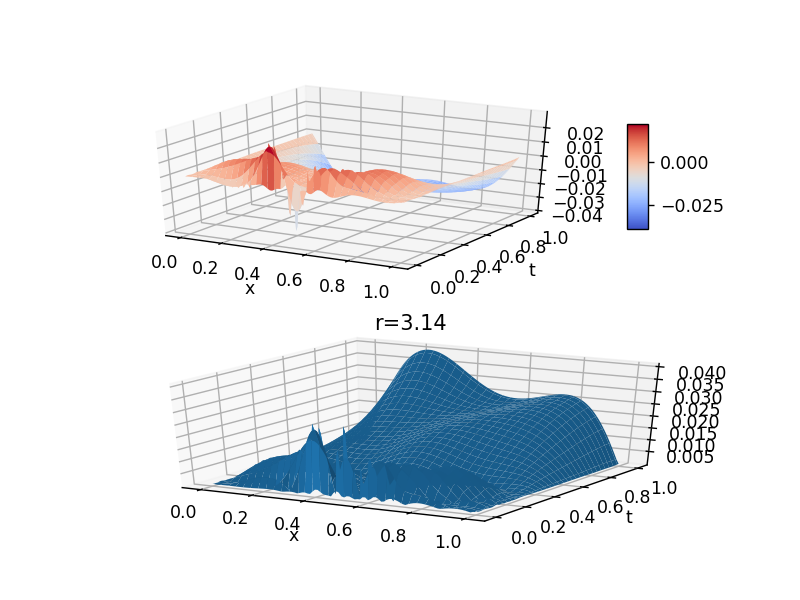

In [10]:
layer = 50
fig = plt.figure()
ax1 = fig.add_subplot(211, projection='3d')
s1 = ax1.plot_surface(x[0].cpu(), t[0].cpu(), err[layer], cmap=cm.coolwarm)
ax1.set_xlabel('x')
ax1.set_ylabel('t')
fig.colorbar(s1, shrink=0.5, aspect=5)

ax2 = fig.add_subplot(212, projection='3d')
ax2.plot_surface(x[0].cpu(), t[0].cpu(), np.abs(err[layer]))
ax2.set_xlabel('x')
ax2.set_ylabel('t')

plt.title('r={:.2f}'.format(ra[layer]));